<br>
<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>
<h1 style="line-height: 1.4;"><font color="#76b900"><b>Rapid Application Development<br>using Large Language Models</b></h1>
<h2><b>Notebook 7.5:</b> Pre-Assessment Primer</h2>
<br>

#### **Congratulations On (Almost) Finishing The Course!** 

**Having found that the final assessment may be challenging, this notebook serves a dual purpose:**
- To prepare you for the assessment, which is only a slight progression beyond the concepts introduced here.
- To provide a direct off-ramp to move in the direction of agents after this course.

#### **This notebook is directly inspired by the NVIDIA Blog Post:**

<blockquote><a href="https://developer.nvidia.com/blog/build-your-first-human-in-the-loop-ai-agent-with-nvidia-nim/" target="_blank">
    <img src="https://developer-blogs.nvidia.com/wp-content/uploads/2024/10/human-ai-agent-interaction-conceptual-architecutre.png"" width="800px"/>
    <h5><b>Build Your First Human-in-the-Loop AI Agent with NVIDIA NIM</b></h5>
</a></blockquote>

<br>

**This blog post also has an [associated video which you may find interesting](https://www.youtube.com/watch?v=mg0kwpmUhPU), but the overall idea is as follows:**

> - We can create a **content creator persona** which generates a structured output format of choice (in this case a social media post).

> - We can create an **image generator pipeline** which not only invokes a diffusion pipeline, but also rephrases its input as a good query.

> - We can use the [**LangGraph library**](https://www.langchain.com/langgraph) as a state management framework to manage communication between our components.
>     - We are excited to be developing material for this area of study as follow-on, so keep an eye out!
>     - We also recommend the [**LangChain Academy courses on LangGraph**](https://academy.langchain.com/courses/intro-to-langgraph) as a good framework-specific starting point. 

> - We can use a **Gradio interface** to deliver our model in a web-based front-end.
>     - We recommend trying [**Building RAG Agents with LLMs course**](https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+S-FX-15+V1) for more use of this interface. This is a natural follow-up to this course.
>     - Additionally, consider exploring [**HuggingFace Spaces**](https://huggingface.co/spaces) which features many custom Gradio-built interfaces with source-accessible deployments.

As our final assessment will require you to develop an image-to-image pipeline in a similar mannar, we believe this is a good opportunity to refresh on the course-specific resources and provide an off-ramp to explore beyond the scope of the class.

### **Setup**

Before we begin, let's set up our environment by importing the necessary libraries and initializing our language model.

In [1]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langchain_nvidia import ChatNVIDIA
from random import random
import json

## In case you restart the notebook, you can start here
model_path = "http://0.0.0.0:9004/v1"
%env NVIDIA_BASE_URL=$model_path
%env NVIDIA_DEFAULT_MODE=open

model_name = "meta/llama-3.3-70b-instruct"

llm = ChatNVIDIA(
    model=model_name, 
    max_tokens=2000, 
    temperature=0
)

env: NVIDIA_BASE_URL=http://0.0.0.0:9004/v1
env: NVIDIA_DEFAULT_MODE=open


<br>

### **7.5.1:** The Content Creator Pipeline

The blog starts by motivating a simple pipeline that generates a document with the following specification using structured output format:

In [2]:
from pydantic import BaseModel, Field, validator
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from typing import List

class StructureOutput(BaseModel):     
    Title: str = Field(description="Title of the promotion message")
    Message : str = Field(description="The actual promotion message")
    Tags: List[str] = Field(description="Hashtags for social media, always starts with #")

## Bind the LLM connector with a structured output request
llm_with_output_structure = llm.with_structured_output(StructureOutput)     

## Construct the content_creator agent
content_creator = PromptTemplate(template="{product_desc}") | llm_with_output_structure
out = content_creator.invoke({"product_desc": "Sim-2-Real Gap with NVIDIA GR00T."})
out

/usr/local/lib/python3.10/dist-packages/langchain_nvidia_ai_endpoints/chat_models.py:814: UserWarning: Model 'meta/llama-3.3-70b-instruct' is not known to support structured output. Your output may fail at inference time.
  warnings.warn(


StructureOutput(Title='Sim-2-Real Gap with NVIDIA GR00T', Message='The sim-2-real gap refers to the challenge of transferring models or policies learned in simulation to the real world, where they often fail to perform as well due to differences in dynamics, perception, and other factors. NVIDIA GR00T is a framework designed to help bridge this gap by providing tools and methodologies for more realistic simulation and better transfer of learned policies to real-world robots.', Tags=['Sim-2-Real', 'NVIDIA GR00T', 'Robotics', 'Simulation', 'Real-World Transfer'])

In [3]:
llm._client.last_inputs

{'url': 'http://0.0.0.0:9004/v1/chat/completions',
 'headers': {'Accept': 'application/json',
  'Authorization': 'Bearer **********',
  'User-Agent': 'langchain-nvidia-ai-endpoints'},
 'json': {'messages': [{'role': 'user',
    'content': 'Sim-2-Real Gap with NVIDIA GR00T.'}],
  'model': 'meta/llama-3.3-70b-instruct',
  'temperature': 0.0,
  'max_tokens': 2000,
  'stream': False,
  'nvext': {'guided_json': {'properties': {'Title': {'description': 'Title of the promotion message',
      'title': 'Title',
      'type': 'string'},
     'Message': {'description': 'The actual promotion message',
      'title': 'Message',
      'type': 'string'},
     'Tags': {'description': 'Hashtags for social media, always starts with #',
      'items': {'type': 'string'},
      'title': 'Tags',
      'type': 'array'}},
    'required': ['Title', 'Message', 'Tags'],
    'title': 'StructureOutput',
    'type': 'object'}}}}

<br>

**NOTE:** The model is able to follow the structured output specifically because it's forced to abide by it. However, there is no instruction regarding what it's supposed to do with this schema. You can see that `guided_json` is being passed into the `build.nvidia.com` endpoint, but it is disregarding our instruction to start the tags with `#` signs. This probably indicates there is no prompt injection happening serverside.

The blog adds an instruction prompt to the guided LLM connector and calls it an "agent," which may agree with intuition but counter our previous observations. More on that later, but let's see the definition:

In [4]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain import prompts, chat_models, hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from pydantic import BaseModel, Field, validator
from typing import Optional, List
 
 
## 1. construct the system prompt ---------
prompt = PromptTemplate(template="""
### [INST]

You are an expert social media content creator.
Your task is to create a different promotion message with the following 
Product Description :
------
{product_desc}
------
The output promotion message MUST use the following format:
'''
Title: a powerful, short message that dipict what this product is about 
Message: be creative for the promotion message, but make it short and ready for social media feeds. Exclude Tags, around 100 words.
Tags: the hash tag human will nomally use in social media
'''
Begin!
[/INST]
""".strip())

## 2. provide seeded product_desc text
description = "Start designing agents with the NVIDIA Agent Blueprint public releases, accessible in Github"
description = "Explore the latest community-built AI models with an API optimized and accelerated by NVIDIA, then deploy anywhere with NVIDIA NIM™ inference microservices."
description = "Get started with LLMs using the HuggingFace Transformer ecosystem, including fine-tuning tutorials regarding robotics and vision-language models."
description = "SOTA LLM Performance with Llama 3.3-70B"
description = "NVIDIA QTX 9090 GPU; 10^10 performance over the 4090; Coming in May 2035"
description = "Bridging the Sim-2-Real Gap with NVIDIA GR00T."

## construct the content_creator agent
content_creator = prompt | llm_with_output_structure
out = content_creator.invoke({"product_desc": description})
out

StructureOutput(Title='Revolutionize Simulation with NVIDIA GR00T', Message='Unlock seamless simulation-to-reality transitions with NVIDIA GR00T. This cutting-edge technology bridges the gap between virtual and real-world environments, empowering innovators to create, test, and deploy with unprecedented accuracy and speed. Experience the future of simulation today!', Tags=['#NVIDIAGR00T', '#Sim2Real', '#AI', '#Innovation', '#Technology'])

<br>

**Note:** We're using direct autoregression to generate the entire document. This may be alright for shorter-form content like this use-case, but should be expected to degrade and generate oversimplified output for most current models. Consider trying a **substring-replacement strategy** - a form of structured output where you specify an old and new substring and perform a replacement - when dealing with longer-form documents.

<br>

### **7.5.2:** The Image Generator Pipeline

The blog also introduces the image generator pipeline to allow us to move beyond textual outputs and into the realm of visual content creation. The pipeline in the blog is grounded on an elastic NIM deployment which is optimized for many concurrent users, and adds an LLM-enabled re-phrasing step to move the input from a user question into a good diffusion prompt. **This is representative of what happens in popular image generation frameworks like Dalle behind the scenes**.

In this example, the pipeline is recreated using your running SDXL FastAPI deployment, which is not optimized for fast inference or concurrent invocation, but is sufficient for this purpose and occupies just a small fraction of your allocated GPU. ***Feel free to use an API of choice if you have access to it!***

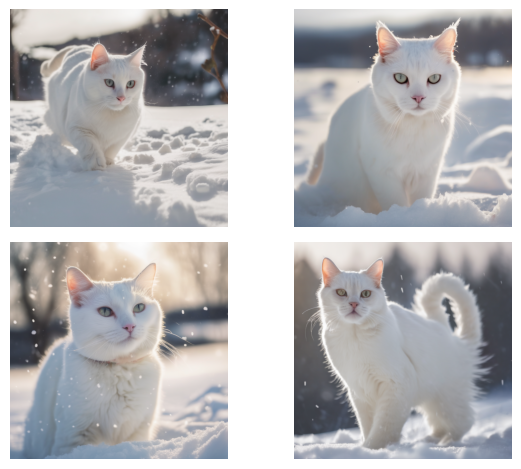

In [5]:
import requests
import base64, io
from PIL import Image
import requests, json
from openai import OpenAI
import matplotlib.pyplot as plt

## Recreation of the generate_image pipeline from Notebook 6
def generate_image(prompt: str, n: int = 4) -> str:
    client = OpenAI(base_url="http://0.0.0.0:9003/v1", api_key="dummy_key")
    response = client.images.generate(
        model="whichever",  ## not actually important
        prompt=prompt,
        size="512x512",
        n=n,
    )
    return [entry.url for entry in response.data]

def plot_imgs(image_paths, r=2, c=2):
    fig, axes = plt.subplots(r, c)
    for i, ax in enumerate(getattr(axes, "flat", [axes])):
        img = plt.imread(image_paths[i])
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

image_paths = generate_image("An awesome white cat playing in the snow")
plot_imgs(image_paths, 2, 2)

<br>

The pipeline above offers raw access to the diffusion model which requires some diffusion prompting know-how, and the pipeline below removes that barrier of entry by mapping conversational responses into effective inputs. 

**Note:** While this would simplify and improve the average user's experience, it also hinders the amount of control an experiences user has over the process. This is a common trade-off of thin LLM-enabled function wrappers, and should not be ignored. However, it is also a highly-effective interface simplifier when implemented strategically. Perhaps a solution which allows for both levels of access might be preferred?

In [ ]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain import prompts, chat_models
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

## Recreation of the llm_rewrite functionality from the blog
def llm_rewrite_to_image_prompts(user_query):
    prompt = prompts.ChatPromptTemplate.from_messages([
        ("system", 
             "Create a stable diffusion prompt that matches the user's intention,"
             " solidifying good topics and keywords for best results."
             " Respond only with abrupt directives, comma separated,"
             " as a text gen model would expect. Keep it short and sweet."
        ), ("user", "{input}"),
    ])
    model = ChatNVIDIA(model="meta/llama-3.3-70b-instruct")
    chain = prompt | model | StrOutputParser()
    out = chain.invoke({"input": user_query})
    return out

image_prompt = llm_rewrite_to_image_prompts("An awesome white cat playing in the snow")
print("New Prompt:", image_prompt)
image_paths = generate_image(image_prompt)
plot_imgs(image_paths, 2, 2)

New Prompt: generate image, white cat, snow, playful, whiskers, fur, winter scene, feline, animal, innocent, serene, joyful, magical, realistic, detailed, high-contrast, colorful, bright.


<br>

To combine these two pipelines into a unified runnable, we could elect to either:
- Make a direct sequential pipeline where each component fully consumes its inputs to produce an output.
- Make a sequential pipeline that accumulates a running state so that every variable is available to every potential branching pipeline.

For this kind of process, the [LangChain `RunnablePassthrough`](https://python.langchain.com/v0.1/docs/expression_language/primitives/passthrough/) - a seemingly do-nothing primitive of the runnable type - is extremely important and is showcased below:

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from functools import partial
from operator import itemgetter

## LCEL Helper Methods
RPass = RunnablePassthrough
RAssign = RunnablePassthrough.assign
def RPrint(*args, **kwargs):
    return RunnablePassthrough(partial(print, *args, **kwargs))

sd_request = (
    "Show me a magical scene with large language models!" 
    " I'd love to see it all fleshed out with shades of nvidia green!"
)

## Use LCEL to construct simple Digital Artist Agent
digital_artist = (
    ## Initial RunnablePassthrough; Implicitly makes subsequent functions as Runnables
    RPass() 
    | llm_rewrite_to_image_prompts 
    | RPrint("SDXL Prompt:")
    ## Pre-fill generate_image with n=1 on passthrough
    | partial(generate_image, n = 1)
    | RPrint("Generated Images:")
)

new_img = digital_artist.invoke(sd_request)
plot_imgs(new_img, 1, 1)

## Use LCEL to construct running-state Digital Artist Agent
digital_artist = (
    RPass()
    ## Coerce input to dict with key "description". Explicitly makes function (and subsequent ones) Runnables
    | (lambda state: state if isinstance(state, dict) else {"description": state})
    ## Instead of overriding the state, add to the state
    | RAssign(sd_prompt = RPass() | itemgetter("description") | llm_rewrite_to_image_prompts)
    | RPrint("State After Prompt Creation:")
    | RAssign(image_files = RPass() | itemgetter("sd_prompt") | generate_image)
    | RPrint("State After Image Generation:")
)

new_imgs = digital_artist.invoke(sd_request)["image_files"]
plot_imgs(new_imgs, 2, 2)

In [ ]:
## In contrast, compare the same request when you try to pass it to sdxl directly
print(sd_request)
new_imgs_direct = generate_image(sd_request)
plot_imgs(new_imgs_direct, 2, 2)

<br>

### **7.5.3:** Combining The Two Pipelines Together

To wrap up this section, we can use the running state abstraction to combine our two processes and execute the main objective of the blog post. You're free to use this as an opportunity to exercise your pipeline creation skill, but the main objective is to give you some practice for the assessment and so a potential solution is provided below. 

In [ ]:
from langchain_core.runnables import RunnableLambda
from IPython.display import HTML, display
from operator import itemgetter

## TODO: Try your example of choice
description = "Start designing agents with the NVIDIA Agent Blueprint public releases, accessible in Github"
description = "Explore the latest community-built AI models with an API optimized and accelerated by NVIDIA, then deploy anywhere with NVIDIA NIM™ inference microservices."
description = "Get started with LLMs using the HuggingFace Transformer ecosystem, including fine-tuning tutorials regarding robotics and vision-language models."
description = "SOTA LLM Performance with Llama 3.3-70B"
description = "Bridge the Sim-2-Real Gap with NVIDIA GR00T."
description = "Start designing agents with the NVIDIA Agent Blueprint public releases, accessible in Github"

state = {"product_desc": description}

image_content_pipe = (
    RAssign(elements = content_creator)
    | RPrint("After Post Creation")
    | RAssign(sd_prompt = RPass() | (lambda s: s.get("product_desc")+"\n"+s.get("elements").Message) | llm_rewrite_to_image_prompts)
    | RPrint("After Prompt Generation")
    | RAssign(img_files = RPass() | itemgetter("sd_prompt") | generate_image)
    | RPrint("After Image Generation")
)

<details>
<summary><b>Solution</b></summary>

```python
image_content_pipe = (
    RAssign(elements = content_creator)
    | RPrint("After Post Creation")
    | RAssign(sd_prompt = RPass() | (lambda s: s.get("product_desc")+"\n"+s.get("elements").Message) | llm_rewrite_to_image_prompts)
    | RPrint("After Prompt Generation")
    | RAssign(img_files = RPass() | itemgetter("sd_prompt") | generate_image)
    | RPrint("After Image Generation")
)
```

</details>

--- 

When you're ready, go ahead and visualize the result, and you'll see that you have generated a fast, quick, and easy AI-generated response using the template below:

In [ ]:
from IPython.display import HTML, display
import base64
from pathlib import Path
from io import BytesIO
from PIL import Image

def image_to_base64(image_path, max_width=300):
    """Convert an image file to a base64 string and resize it for faster loading."""
    image_path = Path(image_path)
    if image_path.exists():
        with Image.open(image_path) as img:
            img.thumbnail((max_width, max_width))
            buffer = BytesIO()
            img.save(buffer, format="PNG")
            return base64.b64encode(buffer.getvalue()).decode("utf-8")
    return None

def render_state(state, return_html=False):
    """Render the state dictionary as an interactive HTML card."""
    # Extract state details
    product_desc = state.get("product_desc", "")
    elements = state.get("elements", {})
    title = getattr(elements, "Title", "Title not available")
    message = getattr(elements, "Message", "Message not available")
    tags = getattr(elements, "Tags", [])
    sd_prompt = state.get("sd_prompt", "")
    img_files = state.get("img_files", [])

    # Generate tags and image grid
    tags_html = " ".join([f"<span class='tag'>{tag}</span>" for tag in tags])
    images_html = "".join([
        f"<div class='image-container'><img src='data:image/png;base64,{image_to_base64(img)}' class='image' /></div>"
        for img in img_files if image_to_base64(img)
    ])

    # HTML template
    html_content = f"""
    <style>
        .card {{
            max-width: 700px;
            margin: 20px auto;
            border: 1px solid #ddd;
            border-radius: 10px;
            font-family: Arial, sans-serif;
            overflow: hidden;
            box-shadow: 0px 4px 6px rgba(0, 0, 0, 0.1);
        }}
        .card-header {{
            background: #76B900;
            color: #fff;
            padding: 15px;
            font-size: 18px;
        }}
        .card-body {{
            padding: 15px;
        }}
        .tags {{
            margin-bottom: 10px;
        }}
        .tag {{
            display: inline-block;
            background: #e1ecf4;
            color: #0366d6;
            padding: 3px 6px;
            border-radius: 3px;
            font-size: 12px;
            margin: 2px;
        }}
        .description {{
            font-size: 14px;
            color: #555;
            margin-bottom: 15px;
        }}
        .images {{
            display: grid;
            grid-template-columns: repeat(2, 1fr);
            gap: 10px;
        }}
        .image-container {{
            overflow: hidden;
            border-radius: 10px;
        }}
        .image {{
            width: 100%;
            transition: transform 0.3s ease;
        }}
        .image:hover {{
            transform: scale(1.2);
        }}
        .card-footer {{
            font-size: 12px;
            color: #666;
            background: #f6f8fa;
            padding: 10px;
        }}
    </style>
    <div class="card">
        <div class="card-header">{title}</div>
        <div class="card-body">
            <p>{message}</p>
            <p class="description">{product_desc}</p>
            <div class="tags">{tags_html}</div>
            <div class="images">{images_html}</div>
        </div>
        <div class="card-footer">Prompt: {sd_prompt}</div>
    </div>
    """
    if return_html: return html_content
    else: display(HTML(html_content))


render_state(new_state)

<br>

#### **Tangent: Is This Sufficient For Production?**

If you squint at this result, you may notice that it looks a lot like some of the AI-generated content being delivered en-masse on social media. It was easy enough to motivate an implementation in an introductory notebook, so it's no surprise that people are able to one-clickify it out in the wild to make a bit of money at the expense of posting low-quality high-volume content. 

**With that said, this is the simplest possible implementation of such a pipeline.** Some natural extensions you may consider include:
- Slicing the pipeline into independently-invocable units. This would allow human intervention throughout the pipeline, which would enable professionals to iterate on ideas rapidly and prototype off of their initializations.
- An agentic loop where a feedback system criticizes the output and suggests modifications. In this formulation, you could try to progress towards an equilibrium state where the feedback system is satisfied with the result. 
    - Note how a human could be the feedback system, in which case your formulation degenerates into a chatbot. Alternatively, the feedback system could be primarily executed by another agent system, in which case you are working with a multi-agent system. Both of those options would be great improvements.

<br>

#### **Tangent: How Is This An Agent?**

In the blog post, these components are described as "agents," and the end objective is to connect them via an agentic orchestration framework like LangGraph. This label is a simplification that likely resonates well with AI enthusiasts, but may run counter to our formalization of "agent," so what should you be thinking? In general, the current trend is to formalize these concepts as follows:

- **The process implemented by the content generation module is just guided auto-regression,** so every token is just one token generated after another after another. However, to a layperson or end-user, the process may feel like the system has agency, personality, and internal thought - it seems to understand language and common facts, after all. As such, this is sometimes called an agent, but is truly just a model-enabled forecasting function. Formally, this type of system has no explicit control over its its own internal state aside from the accumulation of autoregressive generation, which impacts the trajectory of the generated sequence. 
- **The process implemented by the image generator involving multiple LLM calls progressing a representation. This can be thought of as an LLM pipeline or *maybe* a cognitive architecture,** and its execution can be thought of as "thought" if only because engineering effort could be made to design information bottlenecks and enforce certain state variables to follow explicit reasoning. Formally, this type of system has human-engineered control over its own internal state, and it can be argued that this system may have the capacity to "think" in addition to forecasting output word sequences... by forecasting non-output-word sequences as well (or using other language modeling systems).
- **A pipeline capable of explicitly changing the external environment, observing a version of the impact, and acting on it without explicit human intervention may be argued to be more of a true "agent,"** even if it may not have all of the capabilities of a human. (Not that such an agent is impossible to construct at least superficially). The questions of whether it could be empowered to interact with a physical environment, change its own directives, or develop non-trivial internal ontologies is a design decision limited by human interests and primitive LLM capabilities.

The issue with these definitions is that given an endpoint with a natural-language interface, it may be non-trivial to an outside user which system they are actually interacting with - barring advertisement from those hosting said systems. **As such, any one of these options can colloquially be called an agent in good faith.**

<br>

#### **Tangent: Why Would You Use An Agentic Framework Like LangGraph?**

In order to enable this functionality in the blog, the author motivates and uses [**LangGraph**](https://www.langchain.com/langgraph)'s state graph abstraction. **Essentially, this involves setting up a graph system where the nodes are functions and the edges carry states between the nodes.** We were able to achieve this same functionality using the `RunnablePassthrough` primitive, so why bother learning a dedicated framework?

**The answer is actually quite simple:**
- It's an agreed-upon set of abstractions with extra agent-specific considerations baked in.
- Many people are publishing amazing examples using this abstraction, so it's best to get familiar with it.

You should feel free to implement your own orchestration logic and would be better off thinking critically about your actual objectives and requirements instead of blindly following what's popular. With that said, LangGraph does hide a surprising amount of complexity, handle a bunch of edge cases you may not know about, and supports so many examples that it is definitely worth learning at least to start out. If nothing else, we encourage you to try it out after the course and see what kinds of end-user workflows are available out-of-the-box. 

<br>
<hr>

### <font color="#76b900"><b>**Great Job Finishing The Assessment Prep!**</b></font>
#### **Please remember to go to Notebook 8 to test your understanding!**

<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>